In [21]:
import os
import sys
import pandas as pd

sys.path.append('../')

import torch

from PIL import Image
import moviepy.editor as mpy
from IPython.core.display import display, HTML

from torch.nn import functional as F
from torch.autograd import Variable
from math import ceil
from models import TSN
import torchvision
from transforms import *
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import euclidean_distances
import torch.nn.functional as F
from multiprocessing import Pool


def load_model(useGPU=True):
    model = TSN(64,
              8,
              'RGB',
              base_model='InceptionV3',
              consensus_type='TRNmultiscale',
              img_feature_dim=256, print_spec=False)
    
    weight_file = '/home/ec2-user/gif-recommendations/model_train/trn_moments_model/trn_pytorch/TRN_custom_RGB_InceptionV3_TRNmultiscale_segment8_best.pth.tar'
    
    if useGPU:
        model = model.cuda()
        checkpoint = torch.load(weight_file)
    else:
        checkpoint = torch.load(weight_file, map_location=lambda storage,
                                loc: storage)  # allow cpu

    base_dict = {'.'.join(k.split('.')[1:]): v for k, v in list(checkpoint['state_dict'].items())}
    model.load_state_dict(base_dict)
    model.eval()
    model.train(False)
    
    for p in model.parameters():
        p.requires_grad = False
    
    return model


def load_transform():
    """Load the image transformer."""
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda frames: [Image.fromarray(x) for x in frames]),
        GroupOverSample(model.input_size, model.scale_size),
        Stack(roll=True),
        ToTorchFormatTensor(div=False),
        GroupNormalize(model.input_mean, model.input_std),
    ])
    return transform

def evenly_spaced_sampling(array, n):
    """Choose `n` evenly spaced elements from `array` sequence"""
    length = len(array)

    if n == 0 or length == 0:
        return []
    elif n == length:
        return array
    elif n < length:
        return [array[ceil(i * length / n)] for i in range(n)]
    elif n > length:
        result = []
        for _ in range(ceil(n / length)):
            result.extend(array)
        return result[:n]


model = load_model(useGPU=True)

# Load the video frame transform
transform = load_transform()

def process_gif(gif_id, model=model, transform=transform, samples_num=8):
    gif = mpy.VideoFileClip(f'https://media.giphy.com/media/{gif_id}/giphy.mp4')
    frames = evenly_spaced_sampling(list(gif.iter_frames()), samples_num)
    del gif
    
    data = transform(frames)
    with torch.no_grad():
        input_var = torch.autograd.Variable(data.view(-1, 3, data.size(1), data.size(2))).unsqueeze(0).cuda()
    
        # Make video prediction
        logits = model(input_var)
        return logits.cpu().data.numpy().mean(axis=0)
    
def display_gifs(gif_ids, width=150, height_pct=100):
    display(HTML(f"""
        <div style='display: flex; flex-wrap: wrap;'>
            {''.join(f"<a href={get_gif_url(x)} style='width: {width}px; height: {height_pct}%; margin: 5px'><img src={get_gif_url(x)} alt={x} /></a>" for x in gif_ids)}
        </div>
    """))
    
def get_gif_url(id, ext='gif'):
    return f'https://media.giphy.com/media/{id}/giphy.{ext}'

Multi-Scale Temporal Relation Network Module in use ['8-frame relation', '7-frame relation', '6-frame relation', '5-frame relation', '4-frame relation', '3-frame relation', '2-frame relation']
Freezing BatchNorm2D except the first one.
Freezing BatchNorm2D except the first one.


In [52]:
def distance(v1, v2):
    return euclidean_distances(v1.reshape(1, -1), v2.reshape(1, -1)).squeeze(0)[0]

def analyze_pair(gif1, gif2):
    display_gifs([gif1, gif2])
    return gifs_distance(gif1, gif2)

def gifs_distance(gif1, gif2):
    embedding1 = process_gif(gif1)
    embedding2 = process_gif(gif2)
    return distance(embedding1, embedding2)

In [6]:
train = pd.read_csv('/home/ec2-user/gifs/train_videofolder.txt', header=None)
val = pd.read_csv('/home/ec2-user/gifs/val_videofolder.txt', header=None)

In [7]:
val.head()

,0,1,2
0,ih3wJdRgc06uA,50,560
1,13df4adxuQSAww,50,943
2,3oKIPnje70dPDAGlXi,50,1342
3,5pUGoRwSyjPh18Z6gl,50,1182
4,YOjXcDEPnU7kY,50,1243


In [9]:
train = train.groupby(2)[0].apply(list)
val = val.groupby(2)[0].apply(list)

In [10]:
val.head()

2
4                              [jrU2YGXXZOiJO]
6                              [dAS5aQ5mbA6o8]
8     [xT39D66wnoy8uUvkkg, 3o6vY4wVYwGuosjJHW]
9     [NSGAQbgnFbph5wybNX, l1VUuoQB6wkX4cQSW5]
13                        [3oeSAYUUxGQLvXklMs]
Name: 0, dtype: object

In [23]:
embeddings = []
for i, gifs in enumerate(val):
    embeddings.append([process_gif(x) for x in gifs])

In [24]:
import pickle
pickle.dump(embeddings, open('val_embeddings.pkl', 'wb'))

In [45]:
distances = []
for x in embeddings:
    if len(x) > 1:
        matrix = euclidean_distances(x, x)
        i, j = np.triu_indices(matrix.shape[0], 1)
        top_triangle = matrix[i, j]
        distances.append(top_triangle)

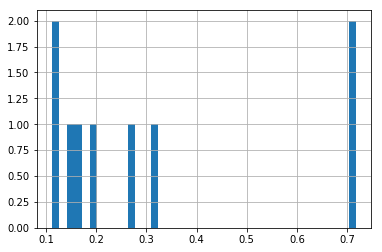

In [27]:
pd.Series([x for matr in distances for x in matr]).hist(bins=40)

In [41]:
import random

negative_distances = []
for x in range(500):
    a, b = random.sample(embeddings, 2)
    vector1, vector2 = random.choice(a), random.choice(b)
    dist = distance(vector1.reshape(1, -1), vector2.reshape(1, -1))
    negative_distances.append(float(dist))

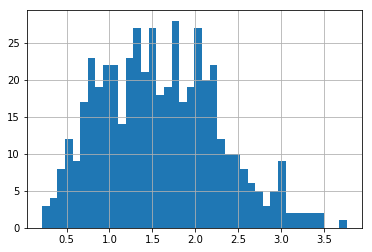

In [42]:
import pandas as pd
pd.Series(negative_distances).hist(bins=40)

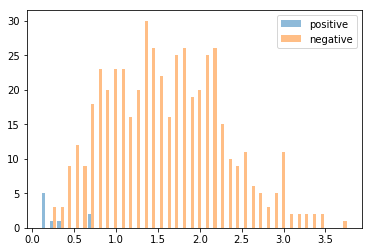

In [48]:
from matplotlib import pyplot

pyplot.hist([[y for x in distances for y in x], negative_distances], bins=40, alpha=0.5, label=['positive', 'negative'])
pyplot.legend(loc='upper right')
pyplot.show()

In [22]:
process_gif('26AHOLVWrGbM4zMys')

array([ 1.53053319e+00,  3.12974095e-01, -1.24196517e+00,  1.24889064e+00,
        4.13135231e-01,  6.46148801e-01,  2.37398058e-01, -2.25126475e-01,
        1.40816784e+00, -6.40569508e-01,  1.13670802e+00,  5.92755556e-01,
        2.08705157e-01,  1.77815646e-01,  2.49315113e-01,  8.36765692e-02,
        8.38631809e-01,  1.17179871e+00, -1.02758214e-01, -1.07741199e-01,
       -1.82863161e-01,  7.08534539e-01,  1.73527837e+00, -3.47257823e-01,
       -6.27079629e-04,  9.18358505e-01,  1.30135560e+00,  8.67556453e-01,
       -2.11393550e-01,  1.64711103e-01,  1.30711114e+00,  2.91908562e-01,
       -3.31317121e-03, -9.62550819e-01,  1.94436097e+00,  1.02786660e+00,
       -4.69677970e-02,  5.79381049e-01,  1.12543011e+00,  5.82446456e-01,
        4.13027346e-01,  9.91362572e-01,  1.12418517e-01, -9.09979165e-01,
        8.20996583e-01,  5.08226752e-01,  7.33701110e-01, -3.77261370e-01,
       -4.75990772e-01,  2.22533226e-01,  4.04569328e-01, -5.06088078e-01,
       -2.87511826e-01, -

In [71]:
import json
import matplotlib.pyplot as plt
from matplotlib.offsetbox import DrawingArea, OffsetImage,AnnotationBbox
from moviepy.editor import VideoFileClip
import warnings
from skimage import io
from skimage.transform import resize
from time import sleep
warnings.filterwarnings('ignore')

np.set_printoptions(precision=4, suppress=True, linewidth=150, threshold=np.nan)
plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

import urllib.request
import urllib.parse

from IPython.core.display import display, HTML
from sklearn.metrics.pairwise import cosine_distances

limit = 10
giphy_api_key = 'a6c4d8d5aceb433ea5bd5fc9f5572ad0'

HAMMING_THRESHOLD = 0.18
SIMILAR_FRAMES_THRESHOLD = 2
SAMPLES = 8


def download_gif(gif_id):
    for i in range(5):
        try:
            clip = VideoFileClip(get_gif_url(gif_id, ext='mp4'))
            break
        except Exception as ex:
            sleep(1)
            print(f'Error: {type(ex)}:{ex}. {i} times. With extension mp4.')
    else:
        for i in range(5):
            try:
                clip = get_gif_url(gif_id, ext='gif')
                break
            except Exception as ex:
                sleep(1)
                print(f'Error: {type(ex)}:{ex}. {i} times. With extension gif.')
    return clip


def siamese_matrix(gif_ids):
    vectors = [process_gif(x) for x in gif_ids]
    return euclidean_distances(vectors, vectors)
    

def gifs_for_query(query, giphy_api_key=giphy_api_key, limit=limit):
    query_string = urllib.parse.urlencode({'api_key': giphy_api_key, 'limit': limit, 'q': query})
    url = f'https://api.giphy.com/v1/gifs/search?{query_string}'
    for i in range(5):
        try:
            response = urllib.request.urlopen(url)
            body = response.read()
            break
        except Exception as ex:
            sleep(1)
            print(f'Error: {type(ex)}:{ex}. {i} times.')
    decoded_json = json.loads(body.decode('utf-8').replace('\n', ''))
    return [x['id'] for x in decoded_json['data']]

def still_image(gif_id):
    return f'https://media0.giphy.com/media/{gif_id}/480w_s.jpg'


def annotate_plt(gif_ids, ax):
    images = []
    for x in gif_ids:
        try:
            im = resize(io.imread(still_image(x)), (200, 200), mode='reflect', anti_aliasing=True)
        except Exception as ex:
            im = np.zeros((200, 200, 3), dtype=np.uint8)
        images.append(im)
    imageboxes = [OffsetImage(x, zoom=0.3) for x in images]
    # x-axis    
    for imagebox, x in zip(imageboxes, np.linspace(0.5, -9.3, len(gif_ids))):
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, (0,0),
                        xybox=(0, 0),
                        xycoords=("data", "axes fraction"),
                        boxcoords="offset points",
                        box_alignment=(x, -10.9),
                        bboxprops={"edgecolor" : "none"})
        ax.add_artist(ab)
    # y-axis
    for imagebox, y in zip(imageboxes, np.linspace(-9.85, 0, len(gif_ids))):
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, (0,0),
                        xybox=(0, 0),
                        xycoords=("data", "axes fraction"),
                        boxcoords="offset points",
                        box_alignment=(1.3, y),
                        bboxprops={"edgecolor" : "none"})
        ax.add_artist(ab)
        
def visual_analysis(query):
    gif_ids = gifs_for_query(query)
    display_gifs(gif_ids)
    print('Distance matrix:')
    matrix = siamese_matrix(gif_ids)
    print(matrix)

    non_diag = matrix[np.triu_indices(matrix.shape[0], 1)]
    print(f'Matrix mean: {np.mean(non_diag)}')
    print(f'Matrix std: {np.std(non_diag)}')
    print(f'Matrix min: {np.min(non_diag)}')
    print(f'Matrix max: {np.max(non_diag)}')

    print('\nHeatmap:')
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    plt.tick_params(axis='both', which='major', labelsize=40)
    ax.imshow(matrix, cmap='hot', interpolation='nearest')
    annotate_plt(gif_ids, ax)
    plt.show()

Distance matrix:
[[0.     1.4583 2.5272 1.9868 0.1975 2.1998 2.057  2.1913 1.7758 2.1482]
 [1.4583 0.     1.2118 0.8599 1.3822 0.8864 0.9853 0.8823 0.5692 0.8109]
 [2.5272 1.2118 0.0039 1.0009 2.4561 0.7309 1.0945 0.7424 1.1135 0.6991]
 [1.9868 0.8599 1.0009 0.     1.9346 0.6717 0.2303 0.6722 1.0232 0.406 ]
 [0.1975 1.3822 2.4561 1.9346 0.0039 2.1388 2.0043 2.1315 1.7044 2.079 ]
 [2.1998 0.8864 0.7309 0.6717 2.1388 0.     0.7185 0.0247 0.7264 0.4934]
 [2.057  0.9853 1.0945 0.2303 2.0043 0.7185 0.     0.7208 1.1546 0.5022]
 [2.1913 0.8823 0.7424 0.6722 2.1315 0.0247 0.7208 0.     0.7191 0.5028]
 [1.7758 0.5692 1.1135 1.0232 1.7044 0.7264 1.1546 0.7191 0.0028 0.9113]
 [2.1482 0.8109 0.6991 0.406  2.079  0.4934 0.5022 0.5028 0.9113 0.0039]]
Matrix mean: 1.1874936819076538
Matrix std: 0.6770992875099182
Matrix min: 0.024705294519662857
Matrix max: 2.5272231101989746

Heatmap:


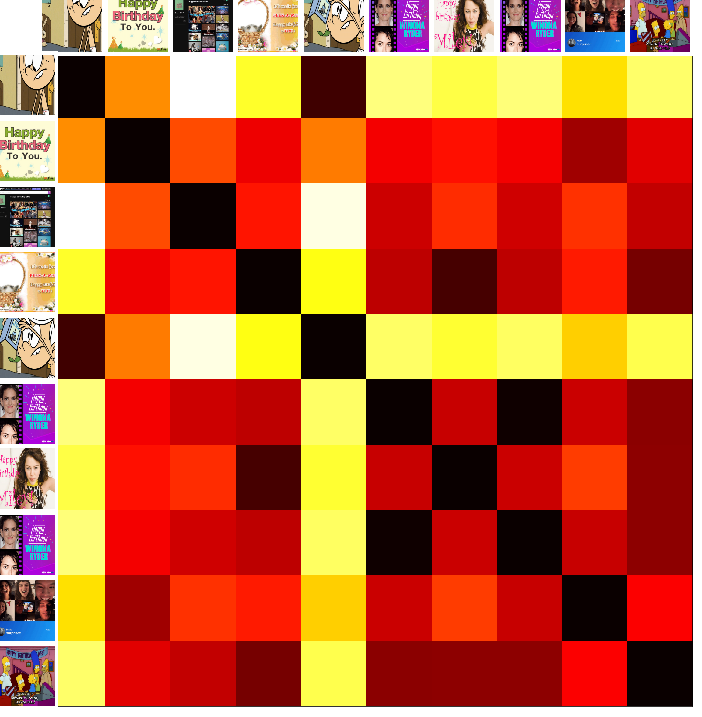

In [81]:
visual_analysis('happy birthd')